In [101]:
import os, sys, math
sys.path.insert(0, '..')

from src import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import smplotlib
from scipy import stats

In [2]:
n_locales_options = [10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000]

n_locations = 1000
n_events = 100
n_locales = 10

### Convergence

In [3]:
MMD_means = []
MMD_stds = []
K_means = []
K_stds = []

for n_locales in n_locales_options:
    print("n_locales:", n_locales)
    MMDs = []
    Ks = []
    for _ in range(10):
        try:
            world = gridworld.GridWorld(
                grid_size=(1000000, 1000000),
                n_locations=n_locations,
                n_locales = n_locales
            )
            actual_distances, locale_intervals = world.sample_event_distances(
                n_events=n_events,
                destination_prob_method="inverse_distance"
            )
        except:
            world = gridworld.GridWorld(
                grid_size=(1000000, 1000000),
                n_locations=n_locations,
                n_locales = n_locales
            )
            actual_distances, locale_intervals = world.sample_event_distances(
                n_events=n_events,
                destination_prob_method="inverse_distance"
            )
        
        teddr1 = teddr.TEDDR(locale_intervals=locale_intervals)

        # --- KS ---
        K = teddr1.ks_distance(actual_distances)
        Ks.append(K)

        # --- MMD ---
        samples1 = teddr1.sample(
            n_samples=n_events, 
            cdf_uncertainty="gaussian"
        )
        MMD = stats.mmd(samples1, actual_distances, False)
        MMDs.append(MMD)
        
    K_means.append(np.mean(Ks))
    K_stds.append(np.std(Ks))
    MMD_means.append(np.mean(MMDs))
    MMD_stds.append(np.std(MMDs))

n_locales: 10
n_locales: 50
n_locales: 100
n_locales: 500
n_locales: 1000
n_locales: 2000
n_locales: 3000
n_locales: 4000
n_locales: 5000


In [4]:
teddr1 = teddr.TEDDR(locale_intervals=locale_intervals)
tedder_samples = teddr1.sample(
    n_samples=100,
    cdf_uncertainty="gaussian"
)

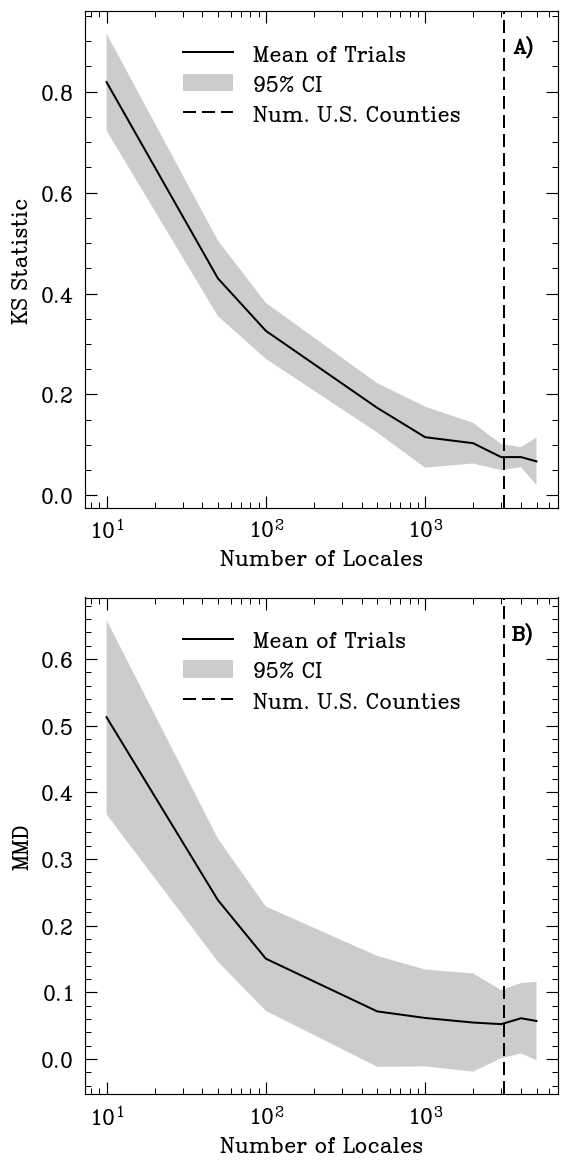

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))

K_means_np = np.array(K_means)
K_stds_np = np.array(K_stds)
CI_upper = K_means_np + 1.96 * K_stds_np
CI_lower = K_means_np - 1.96 * K_stds_np
ax[0].plot(n_locales_options, K_means_np, label='Mean of Trials')
ax[0].fill_between(n_locales_options, CI_lower, CI_upper, alpha=0.2, label='95% CI')
ax[0].axvline(x=3141, ls="--", label="Num. U.S. Counties")
ax[0].set_xlabel("Number of Locales")
ax[0].set_ylabel("KS Statistic")
ax[0].set_xscale("log")
ax[0].legend(loc="upper center")
ax[0].text(0.95, 0.95, 'A)', 
     transform=ax[0].transAxes, 
     verticalalignment='top', 
     horizontalalignment='right', 
     fontweight='bold'
)

MMD_means_np = np.array(MMD_means)
MMD_stds_np = np.array(MMD_stds)
CI_upper = MMD_means_np + 1.96 * MMD_stds_np
CI_lower = MMD_means_np - 1.96 * MMD_stds_np
ax[1].plot(n_locales_options, MMD_means_np, label='Mean of Trials')
ax[1].fill_between(n_locales_options, CI_lower, CI_upper, alpha=0.2, label='95% CI')
ax[1].axvline(x=3141, ls="--", label="Num. U.S. Counties")
ax[1].set_xlabel("Number of Locales")
ax[1].set_ylabel("MMD")
ax[1].set_xscale("log")
ax[1].legend(loc="upper center")
ax[1].text(0.95, 0.95, 'B)', 
     transform=ax[1].transAxes, 
     verticalalignment='top', 
     horizontalalignment='right', 
     fontweight='bold'
)

# sns.kdeplot(tedder_samples, label="Estimate", ax=ax[2], clip=(0, 1.5*10**6))
# sns.kdeplot(actual_distances, label="Actual", ax=ax[2], clip=(0, 1.5*10**6))
# ax[2].set_xlabel("Travel Distance")
# ax[2].legend()
# ax[2].legend(loc="upper center")
# ax[2].text(0.95, 0.95, 'C)', 
#      transform=ax[2].transAxes, 
#      verticalalignment='top', 
#      horizontalalignment='right', 
#      fontweight='bold'
# )

plt.tight_layout()
plt.savefig("simresults_compact.png")
plt.show()

### Calibration

In [136]:
def pct_less(vals, ref):
    return sum(v < ref for v in vals) / len(vals)

def holm_bonferroni(p_values, alpha=0.05):
    """Apply the Holm-Bonferroni method to adjust p-values for multiple comparisons."""
    sorted_p_values = sorted((p, i) for i, p in enumerate(p_values))
    m = len(p_values)
    adjusted_alpha = [alpha / (m - i) for i in range(m)]
    significant = [False] * m
    
    for (p_value, original_index), alpha in zip(sorted_p_values, adjusted_alpha):
        if p_value <= alpha:
            significant[original_index] = True
        else:
            break
    return significant.count(True)

def holm_bonferroni_dict(p_values, alpha=0.05):
    sorted_p_values = sorted((p, i) for i, p in enumerate(p_values))
    m = len(p_values)
    adjusted_p_values = {p: min(alpha / (m - i), 1) for i, (p, _) in enumerate(sorted_p_values)}
    adjusted_p_values_dict = {}
    
    for original_p_value, original_index in sorted_p_values:
        adjusted_p_values_dict[original_p_value] = adjusted_p_values[original_p_value]
    
    return adjusted_p_values_dict

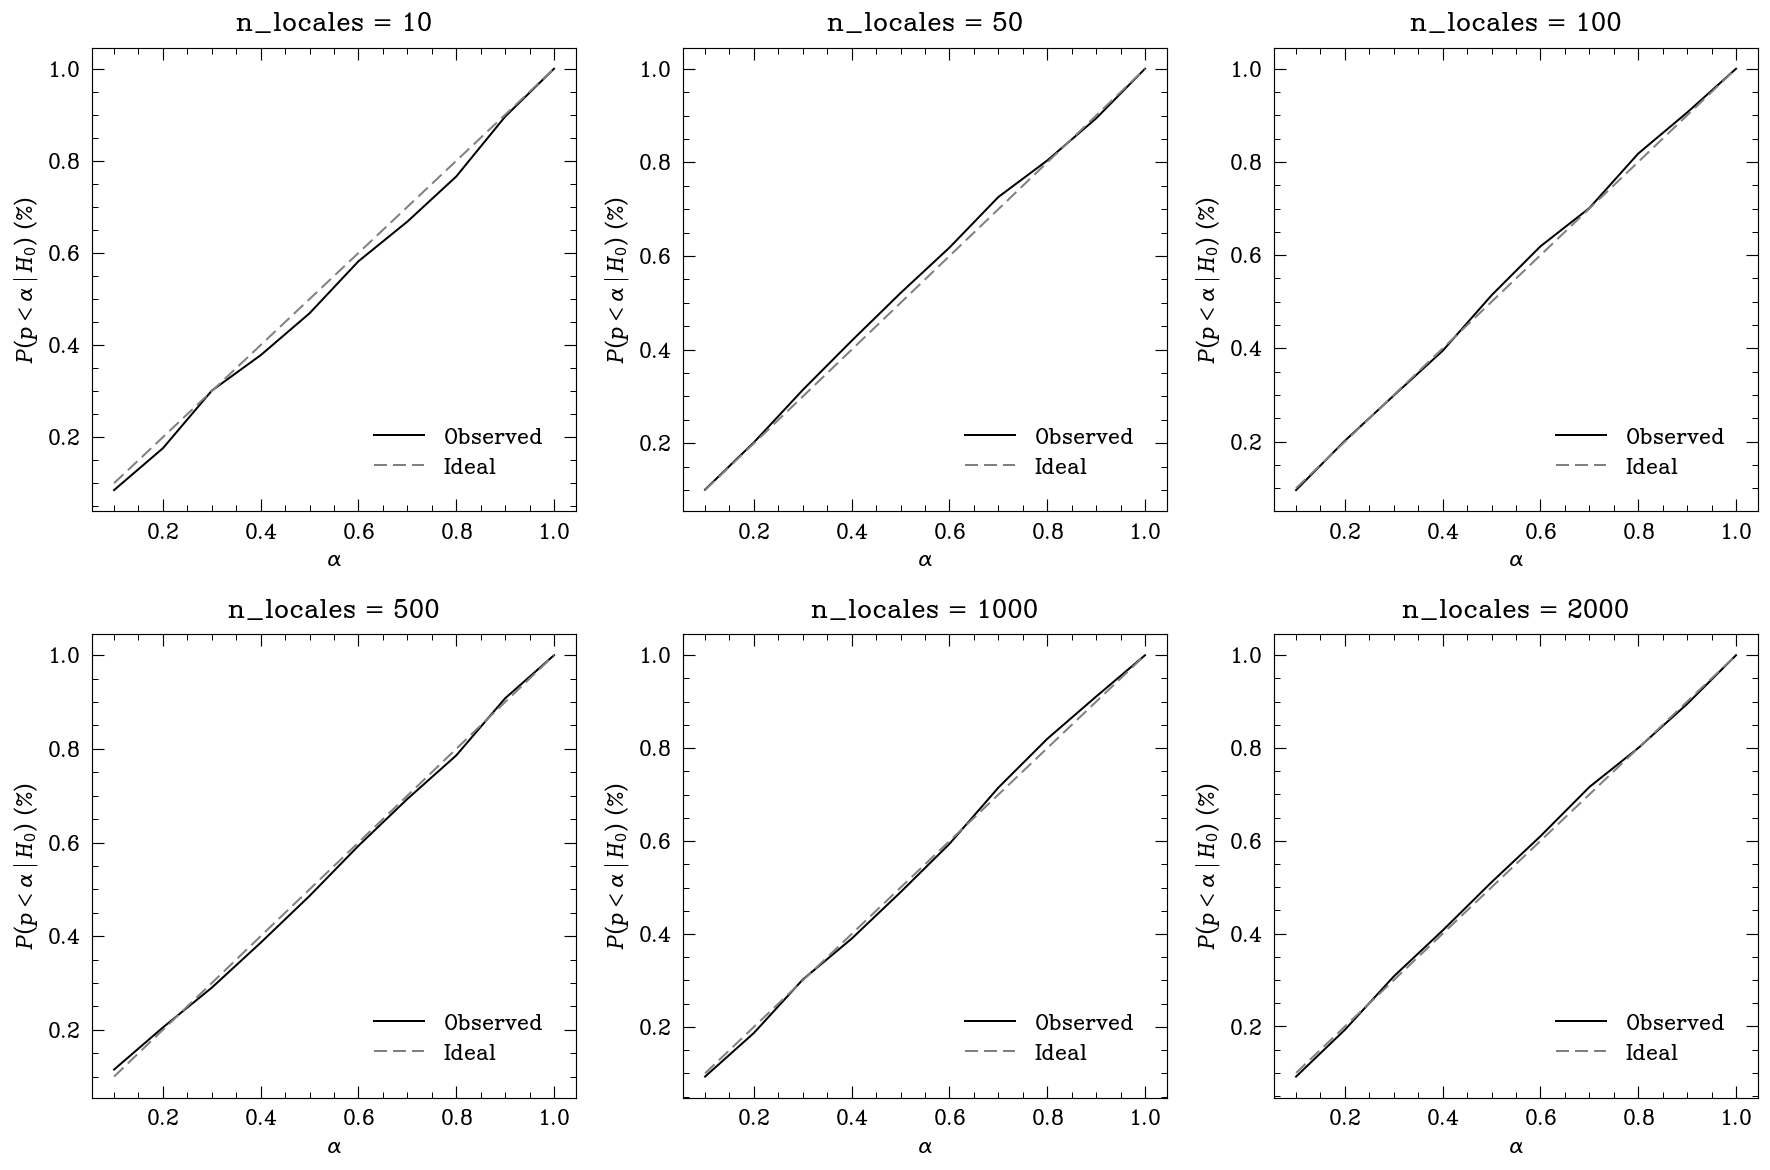

In [132]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes_flat = axes.flatten()
uniform_pvals = []
uniform_chis = []
for idx, n_locales in enumerate(n_locales_options[:6]):
    #---gather p-values---
    p_values = []
    for _ in range(1000):
        try:
            world = gridworld.GridWorld(
                grid_size=(1000000, 1000000),
                n_locations=n_locations,
                n_locales = n_locales
            )
            actual_distances1, locale_intervals1 = world.sample_event_distances(
                n_events=n_events,
                destination_prob_method="inverse_distance"
            )
        except:
            world = gridworld.GridWorld(
                grid_size=(1000000, 1000000),
                n_locations=n_locations,
                n_locales = n_locales
            )
            actual_distances1, locale_intervals1 = world.sample_event_distances(
                n_events=n_events,
                destination_prob_method="inverse_distance"
            )
        tester = teddr.TEDDRTester(
            locale_intervals1=locale_intervals1, 
            locale_intervals2=locale_intervals1,
            cdf_uncertainty="gaussian"
        )
        S, p = tester.utest(100, 100, return_samples=False)
        p_values.append(p)

    #---Type I error maintenance---
    pctiles = [0.1*k for k in range(1, 11)]
    y_values = []
    for x in pctiles:
        y_values.append(pct_less(p_values, x))
    y_values = [pct_less(p_values, x) for x in pctiles]

    #---uniformity of p-values---
    num_bins = 20 # each incremental 5% level
    expected_counts = np.ones(num_bins) * len(p_values) / num_bins
    observed_counts, _ = np.histogram(p_values, bins=np.linspace(0, 1, num_bins + 1))
    chi_square, p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)
    uniform_pvals.append(p_value)
    uniform_chis.append(chi_square)

    # --- plotting---
    ax = axes_flat[idx]
    ax.plot(pctiles, y_values, label='Observed')
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel("$P(p < \\alpha \mid H_0)$ (%)")
    ax.plot(pctiles, pctiles, linestyle="--", color='grey', label='Ideal')
    ax.legend(loc="lower right")
    ax.set_title(f'n_locales = {n_locales}')

plt.tight_layout()
plt.savefig("calibration_null.png")
plt.show()

In [133]:
holm_bonferroni(uniform_pvals)

0

In [131]:
uniform_chis

[22.0, 14.0, 18.0, 18.0, 18.0, 22.0]

In [135]:
uniform_pvals

[0.016659712255616337,
 0.11532681319535366,
 0.4189985652686264,
 0.34123811735660114,
 0.49852396549216804,
 0.43648747317009257]